##Importing libraries

In [2]:
import numpy as np
import pandas as pd
import nltk, re, collections, pickle, os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Reading the Dataset and Data Manipulation





In [3]:
pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:.3f}'.format
df = pd.read_csv('spam.csv', encoding = 'latin-1')
df = df.filter(['v1', 'v2'], axis = 1)
df.columns = ['feature', 'message']
df.drop_duplicates(inplace = True, ignore_index = True)
print('DataFrame Info:\n')
print(df.info())
print('\nNumber of null values:\n')
print(df.isnull().sum())

DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB
None

Number of null values:

feature    0
message    0
dtype: int64


##  Spam Classification using Machine Learning







##Text processing

In [4]:
vocab_size = 1000
embed_dim = 64
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20
drop_level = 0.3
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5
seed = 42
preprocessed_df = []
lemmatizer = WordNetLemmatizer()
for i in range(df.shape[0]):
    message = df.iloc[i, 1]
    message = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', message)
    message = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', message)
    message = re.sub('£|\$', 'moneysymb', message)
    message = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', message)
    message = re.sub('\d+(\.\d+)?', 'numbr', message)
    message = re.sub('[^\w\d\s]', ' ', message)
    message = re.sub('[^A-Za-z]', ' ', message).lower()
    token_messages = word_tokenize(message)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    preprocessed_df.append(txt_mess)
print("Text Processed")

Text Processed


##Vectorization and dumping the vectorization




In [5]:
count_vectorizer = CountVectorizer(max_features=vocab_size)
X_count = count_vectorizer.fit_transform(preprocessed_df)
X_count_array = X_count.toarray()
y = df['feature']
X_train, X_test, y_train, y_test = train_test_split(
    X_count_array, y, test_size=(test_size + valid_size), random_state=seed
)

print(f'Number of rows in test set: {X_test.shape[0]}')
print(f'Number of rows in training set: {X_train.shape[0]}')

tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_df)

tfidf_data = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

with open('TF_IDF.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF vectorizer saved to 'TF_IDF.pkl'")

Number of rows in test set: 1293
Number of rows in training set: 3876
TF-IDF vectorizer saved to 'TF_IDF.pkl'


##Classification models

##Multinomial Naive Bayes



In [6]:
class_MNB = MultinomialNB().fit(X_train, y_train)
y_pred_MNB = class_MNB.predict(X_test)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1107
        spam       0.90      0.92      0.91       186

    accuracy                           0.97      1293
   macro avg       0.94      0.95      0.95      1293
weighted avg       0.97      0.97      0.97      1293
 



###  Decision Tree Classifier.


In [7]:
class_DTC = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
y_pred_DTC = class_DTC.predict(X_test)
class_rep_DTC = classification_report(y_test, y_pred_DTC)
print('\t\t\tClassification report:\n\n', class_rep_DTC, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1107
        spam       0.87      0.84      0.86       186

    accuracy                           0.96      1293
   macro avg       0.92      0.91      0.92      1293
weighted avg       0.96      0.96      0.96      1293
 



###Logistic Regression.


In [8]:
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



###  KNeighbors Classifier.


In [9]:
class_KNC = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred_KNC = class_KNC.predict(X_test)
class_rep_KNC = classification_report(y_test, y_pred_KNC)
print('\t\t\tClassification report:\n\n', class_rep_KNC, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1107
        spam       0.93      0.70      0.80       186

    accuracy                           0.95      1293
   macro avg       0.94      0.84      0.88      1293
weighted avg       0.95      0.95      0.95      1293
 



###  Support Vector Classification.


In [10]:
class_SVC = SVC(probability = True, random_state = seed).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_test)
class_rep_SVC = classification_report(y_test, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.98      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 




## Gradient Boosting Classifier.


In [11]:
class_GBC = GradientBoostingClassifier(random_state = seed).fit(X_train, y_train)
y_pred_GBC = class_GBC.predict(X_test)
class_rep_GBC = classification_report(y_test, y_pred_GBC)
print('\t\t\tClassification report:\n\n', class_rep_GBC, '\n')

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1107
        spam       0.99      0.84      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.92      0.95      1293
weighted avg       0.98      0.98      0.97      1293
 



# Spam Detection using Deep Learning


In [12]:
!pip install transformers
!pip install keras_nlp
!pip install dash

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import keras.layers
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

##Label Transformation.

In [14]:
sentences_new_set = df['message'].values
labels_new_set = df['feature'].values
train_size = int(df.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df.shape[0] * (1 - valid_size))
train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]
train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]
train_labels = [1 if item == 'ham' else 0 for item in train_labels_str]
valid_labels = [1 if item == 'ham' else 0 for item in valid_labels_str]
test_labels = [1 if item == 'ham' else 0 for item in test_labels_str]
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

###  Tokenization.


In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, lower=False)
tokenizer.fit_on_texts(train_sentences)
max_len = 250
padding_type = 'post'
trunc_type = 'post'

def preprocess_texts(tokenizer, texts, max_len, padding_type, trunc_type):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, padding=padding_type, maxlen=max_len, truncating=trunc_type)

train_set = preprocess_texts(tokenizer, train_sentences, max_len, padding_type, trunc_type)
valid_set = preprocess_texts(tokenizer, valid_sentences, max_len, padding_type, trunc_type)
test_set = preprocess_texts(tokenizer, test_sentences, max_len, padding_type, trunc_type)

size_voc = len(tokenizer.word_index) + 1

print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {valid_set.shape}")
print(f"Test set shape: {test_set.shape}")
print(f"Vocabulary size: {size_voc}")


Training set shape: (3876, 250)
Validation set shape: (259, 250)
Test set shape: (1034, 250)
Vocabulary size: 9470


###  Model building.


In [16]:
inputs = keras.layers.Input(shape=(max_len,), dtype=tf.int32)
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(size_voc, max_len, embed_dim)(inputs)
decoder = keras_nlp.layers.TransformerDecoder(intermediate_dim=embed_dim,
                                                            num_heads=8,
                                                            dropout=0.3)(embedding_layer)
gru = layers.Bidirectional(layers.GRU(128, return_sequences=True))(decoder)
avg_pool = layers.GlobalAveragePooling1D()(gru)
max_pool = layers.GlobalMaxPool1D()(gru)
x = layers.Concatenate()([avg_pool, max_pool])
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

###  Model compiling and fitting.


In [17]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.96
)
optim = Adam(learning_rate=lr_schedule)
model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, 250, 64)        │        622,080 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ (None, 250, 64)        │         25,216 │ token_and_position_em… │
│ (TransformerDecoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 250, 256)       │        148,992 │ transformer_decoder[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            513 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 796,801 (3.04 MB)

 Trainable params: 796,801 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)
history = model.fit(
    train_set,
    train_labels,
    epochs=20,
    validation_data=(valid_set, valid_labels),
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.7299 - loss: 0.5181 - val_accuracy: 0.8803 - val_loss: 0.2917
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8684 - loss: 0.2842 - val_accuracy: 0.8919 - val_loss: 0.2414
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9130 - loss: 0.2023 - val_accuracy: 0.9228 - val_loss: 0.1825
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9635 - loss: 0.1245 - val_accuracy: 0.9730 - val_loss: 0.0946
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9816 - loss: 0.0714 - val_accuracy: 0.9846 - val_loss: 0.0645
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9848 - loss: 0.0578 - val_accuracy: 0.9846 - val_loss: 0.0606
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9899 - loss: 0.0410 - val_accuracy: 0.9807 - val_loss: 0.0576
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9937 - loss: 0.0291 - val_a

##Results visualization.


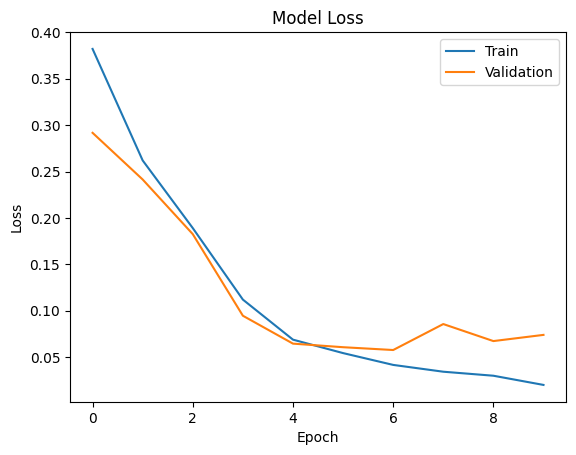

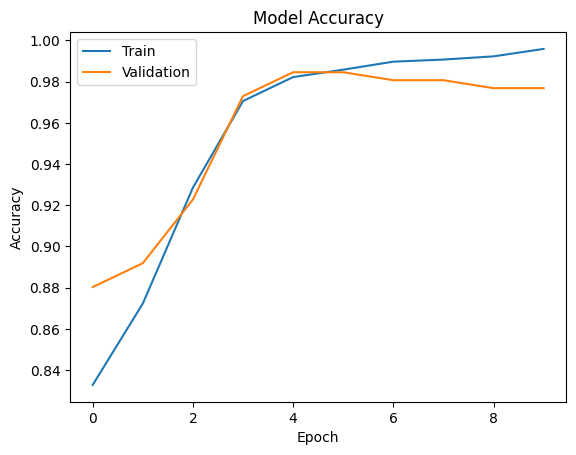

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [20]:
batch_size = 32
model_score = model.evaluate(test_set, test_labels, batch_size=batch_size, verbose=1)
loss = model_score[0]
accuracy = model_score[1]
print(f"Test accuracy: {accuracy * 100:0.2f}% \t\t Test error: {loss:0.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9808 - loss: 0.0623
Test accuracy: 98.26% 		 Test error: 0.0516


##Model saving and predict checking.


In [21]:
from tensorflow.keras.models import load_model
model.save('model1.keras')
threshold = 0.5
y_pred = model.predict(test_set)
y_prediction = (y_pred > threshold).astype(int)
conf_m = confusion_matrix(test_labels, y_prediction)
class_rep = classification_report(test_labels, y_prediction)

print('\t\t\tClassification report:\n\n', class_rep, '\n')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
			Classification report:

               precision    recall  f1-score   support

           0       0.92      0.92      0.92       117
           1       0.99      0.99      0.99       917

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034
 



##Results

In [22]:
from dash import dcc, html, Input, Output, Dash
import plotly.graph_objects as go
app = Dash(__name__)
app.layout = html.Div([
    dcc.Input(id='input-message', type='text', value=input("Enter the message:")),
    html.Button('Classify', id='classify-button', n_clicks=0),
    html.Div(id='result-text'),
    dcc.Graph(id='result-chart')
])

@app.callback(
    [Output('result-chart', 'figure'),
     Output('result-text', 'children')],
    [Input('classify-button', 'n_clicks')],
    [Input('input-message', 'value')]
)
def update_graph(n_clicks, input_message):
    if n_clicks > 0:
        message_tp = pad_sequences(
            tokenizer.texts_to_sequences([input_message]),
            maxlen=max_len,
            padding=padding_type,
            truncating=trunc_type
        )
        pred = model.predict(message_tp)[0][0]
        threshold = 0.5
        classification = "Real Text" if pred > threshold else "Spam Message"

        labels = ['Real Text', 'Spam Message']
        values = [pred, 1 - pred]
        colors = ['green', 'red']
        fig = go.Figure(data=[
            go.Bar(name='Probability', x=labels, y=values, marker_color=colors)
        ])

        fig.update_layout(
            title='Message Classification Probability',
            xaxis_title='Category',
            yaxis_title='Probability',
            yaxis=dict(range=[0, 1]),
            template='plotly_dark'
        )
        fig.add_annotation(
            text=f"Classification: {classification}",
            x=0.5,
            y=1.05,
            showarrow=False,
            xref='paper',
            yref='paper',
            font=dict(size=16, color='black'),
            align='center'
        )
        return fig, f"This message is classified as: {classification}"
    return go.Figure(), "Please enter a message and click 'Classify'"

if __name__ == '__main__':
    app.run_server(debug=True)


Enter the message:hello nice to meet you


<IPython.core.display.Javascript object>